In [1]:
import pandas as pd
import numpy as np
from tsa.preprocessing import get_sample_info, tpm_normalization
from tsa.gpr import gpr
from tsa.gene_selection import score_normalization, plot_scores, best_n_genes
from tsa.tsa import best_alignment_graph, plot_alignment
from tsa.utils import list2floats, inference_timeseries
from tsa.plotting import plot_alignments
from qnorm import quantile_normalize
import os

In [2]:
from scipy.spatial.distance import cdist

def get_cost_matrix(template_tpms, query_tpms, metric='euclidean'):
    template = template_tpms.to_numpy(dtype=np.float64)
    query = query_tpms.to_numpy(dtype=np.float64)
    cost_matrix = cdist(template.T, query.T, metric=metric).T  # pairwise distance matrix
    return cost_matrix

In [3]:
# get all orthologue genes
df = pd.read_csv("orthologs/mart_export.txt", sep="\t", dtype=str)
df = df.rename(columns={
    "Tropical clawed frog gene name": "xt_name",
    "Tropical clawed frog gene stable ID": "xt_id",
    "Gene name": "dr_name",
    "Gene stable ID": "dr_id",
}, errors="raise")
df = df.dropna(subset=["xt_id", "dr_id"])

tpm_file = "data/GRCz11-TPM.tsv"
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

df = df[df["dr_id"].isin(tpms.index)]

tpm_file = "data/XT9.1-TPM.tsv"
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

df = df[df["xt_id"].isin(tpms.index)]

orthologs = df
orthologs

,xt_name,xt_id,dr_name,dr_id
3,ostc,ENSXETG00000021099,ostc,ENSDARG00000104901
4,rab9b,ENSXETG00000018133,rab9b,ENSDARG00000103391
5,tppp3,ENSXETG00000000345,tppp3,ENSDARG00000030463
6,slc39a9,ENSXETG00000017909,slc39a9,ENSDARG00000070447
7,gpkow,ENSXETG00000007727,gpkow,ENSDARG00000029612
...,...,...,...,...
26226,lgi4,ENSXETG00000016869,lgi1a,ENSDARG00000020493
26227,pak1,ENSXETG00000010703,pak1,ENSDARG00000103959
26229,bnip1,ENSXETG00000012728,bnip1b,ENSDARG00000104280
26230,piezo2,ENSXETG00000004054,PIEZO2,ENSDARG00000107086


In [4]:
# create a df where each ID occurs once, so we can order the TPMs for quantile normalization
df = orthologs.copy()
df = df[~df["dr_id"].duplicated()]
df = df[~df["xt_id"].duplicated()]
df = df.sort_values("dr_id")
orthologue_order = df

orthologue_order

,xt_name,xt_id,dr_name,dr_id
10819,slc35a5,ENSXETG00000002426,slc35a5,ENSDARG00000000001
10811,ccdc80,ENSXETG00000002427,ccdc80,ENSDARG00000000002
9654,nrf1,ENSXETG00000016306,nrf1,ENSDARG00000000018
9266,slc9a3r1,ENSXETG00000006840,slc9a3r1a,ENSDARG00000000068
4275,itsn1,ENSXETG00000014182,itsn1,ENSDARG00000000086
...,...,...,...,...
21483,inf2,ENSXETG00000008613,CABZ01060373.1,ENSDARG00000117069
22759,cks2,ENSXETG00000010855,CKS2,ENSDARG00000117089
22378,ppp1r12b,ENSXETG00000017095,BX323087.1,ENSDARG00000117155
21688,NaN,ENSXETG00000014018,CR392001.3,ENSDARG00000117159


In [5]:
# df = orthologs
# df = df.sort_values("xt_id")
# # df["xt_id"].duplicated()
# # df["dr_id"].duplicated()
# df[df["xt_id"].duplicated()]

In [6]:
# dr_id2name = "/bank/genomes/GRCz11/gene_id2name.tsv"
# xt_id2name = "/bank/genomes/Xenopus_tropicalis_v9.1/gene_id2name.tsv"

In [7]:
# import genomepy
# grcz11 = genomepy.Annotation("GRCz11", genomes_dir="/bank/genomes")
# dr_gtf = grcz11.named_gtf
# # dr_gtf

In [8]:
# xt91 = genomepy.Annotation("Xenopus_tropicalis_v9.1", genomes_dir="/bank/genomes")
# xt_gtf = xt91.named_gtf
# # xt_gtf

In [9]:
# import re

# def get_id(row):
#     hit = re.findall('gene_id ".*?";', row)
#     if hit:
#         gene_id = hit[0].split('"')[1]
#         return gene_id

# for row in dr_gtf["attribute"]:
#     print(row)
#     break
# get_id(row)

### manual gene selection

In [10]:
# orthologs[orthologs.xt_id == "ENSXETG00000019924"]

In [11]:
# genes = list(tpms.index.unique())
genes = list(orthologs["dr_name"].unique())

In [12]:
selected_genes_df = orthologs.copy().head(0)

In [13]:
query = "hoxd10a"
hits = [g for g in genes if str(g).startswith(query)]
for hit in hits:
    print(df[df["dr_name"] == hit])

     xt_name               xt_id  dr_name               dr_id
6348  hoxd10  ENSXETG00000007580  hoxd10a  ENSDARG00000057859


In [14]:
selected_genes_df = pd.concat([selected_genes_df, df[df["dr_name"] == hit]])
selected_genes_df

,xt_name,xt_id,dr_name,dr_id
6348,hoxd10,ENSXETG00000007580,hoxd10a,ENSDARG00000057859


In [15]:
# selected_genes_dict["dr_name"].to_list()
# ['sox21b',
#  'foxb1a',
#  'eomesa',
#  'gata6',
#  'hoxa1a',
#  'hoxa2b',
#  'hoxa4a',
#  'hoxa5a',
#  'hoxa9a',
#  'hoxa10b',
#  'hoxa11a',
#  'hoxa13a',
#  'hoxd4a',
#  'hoxd9a',
#  'hoxd10a']

In [16]:
hits = [
    'hoxa1a',
    'hoxa2b',
    'hoxa4a',
    'hoxa5a',
    'hoxa9a',
    'hoxa10b',
    'hoxa11a',
    'hoxa13a',
    'hoxd4a',
    'hoxd9a',
    'hoxd10a',
]

df = orthologs.copy()
hox_df = orthologs.copy().head(0)
for hit in hits:
    hox_df = pd.concat([hox_df, df[df["dr_name"] == hit]])
    
hox_df

,xt_name,xt_id,dr_name,dr_id
5849,hoxa1,ENSXETG00000000715,hoxa1a,ENSDARG00000104307
2059,hoxa2,ENSXETG00000000716,hoxa2b,ENSDARG00000023031
6661,hoxa3,ENSXETG00000000717,hoxa4a,ENSDARG00000103862
4297,hoxa5,ENSXETG00000000720,hoxa5a,ENSDARG00000102501
6678,hoxa9,ENSXETG00000000724,hoxa9a,ENSDARG00000105013
6232,hoxa10,ENSXETG00000000728,hoxa10b,ENSDARG00000031337
6657,hoxa11,ENSXETG00000000732,hoxa11a,ENSDARG00000104162
5835,hoxa13,ENSXETG00000000734,hoxa13a,ENSDARG00000100312
904,hoxd4,ENSXETG00000001799,hoxd4a,ENSDARG00000059276
4440,hoxd9,ENSXETG00000007581,hoxd9a,ENSDARG00000059274


In [17]:
# selected_genes_df = hox_df

### dirty auto gene selection

In [18]:

# orthologs = df
# orthologs = orthologs.drop_duplicates(["xt_id"])
# orthologs = orthologs.drop_duplicates(["dr_id"])
# orthologs = orthologs.sort_values("dr_id")


In [19]:
# # keep only the first ortholog (dirty)
# df = orthologs.copy()
# df = df[~df["dr_id"].duplicated()]
# df = df[~df["xt_id"].duplicated()]
# df = df.sort_values("dr_id")
# selected_genes_df = df.sample(500)

# selected_genes_df

In [20]:
# selected_genes_dict = {
#     # gene_names           foxa1                 sox21                 eomes                 gata6                 hoxa1               pou6f2
#     "xenopus":    ["ENSXETG00000017708", "ENSXETG00000010955", "ENSXETG00000019924", "ENSXETG00000003144", "ENSXETG00000000715", "ENSXETG00000005600"],
#     "zebrafish":  ["ENSDARG00000089042", "ENSDARG00000008540", "ENSDARG00000104243", "ENSDARG00000103589", "ENSDARG00000104307", "ENSDARG00000086362"],
# }

In [21]:
# grcz11 = {
#     "ENSDARG00000070913": "sox2",
#     "ENSDARG00000044774": "oct4",
#     "ENSDARG00000102138": "foxa1",
#     "ENSDARG00000006640": "eomesa",
# #     "ENSDARG00000075113": "nanog",
#     "ENSDARG00000103589": "gata6",
#     "ENSDARG00000054033": "hoxb1b",
#     "ENSDARG00000070339": "hoxc3a",
#     "ENSDARG00000031246": "hbegfb",
# }
# xt91 = {
#     "ENSXETG00000036807": "sox2",
#     "ENSXETG00000026475": "oct4",  # pou5f3.1
#     "ENSXETG00000025867": "foxa1",
#     "ENSXETG00000019924": "eomesa",
# #     "": "nanog",
#     "ENSXETG00000003144": "gata6",
#     "": "hoxb1b",
#     "": "hoxc3a",
#     "": "hbegfb",
# }

In [22]:
# template
tpm_file = "data/GRCz11-TPM.tsv"
template_samples_file = "data/white_mpf_samples.tsv"

template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(template_samples)

tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

# filter & order
template_tpms = tpms[sample_order]
# selected_genes = list(orthologs["dr_id"])
# selected_genes = selected_genes_dict["zebrafish"]
# selected_genes = selected_genes_df["dr_id"].to_list()
gene_order = orthologue_order["dr_id"].to_list()
template_tpms = template_tpms.loc[gene_order]

# average replicates
for timepoint in time2samples:
    template_tpms[timepoint] = template_tpms[time2samples[timepoint]].mean(axis=1)
template_tpms = template_tpms.filter(items=time2samples.keys())

template_tpms = template_tpms[template_tpms.max(axis=1) >= 5]  # filter genes

# quantile normalize & transform
template_tpms = quantile_normalize(template_tpms, axis=1)
template_tpms = np.log2(template_tpms+1)

template_tpms

,0.0,45.0,135.0,180.0,259.8,315.0,360.0,480.0,619.8,960.0,1140.0,1440.0,1800.0,2160.0,2880.0,4320.0,5760.0,7200.0
gene,,,,,,,,,,,,,,,,,,
ENSDARG00000000001,3.114526,3.120884,3.290378,3.279359,2.843935,2.719675,2.762640,2.850424,2.031532,1.600010,1.422191,1.342443,1.345496,1.138991,1.381466,0.891870,0.950721,1.116550
ENSDARG00000000002,1.618934,2.638195,1.832498,1.693940,1.264234,1.002551,0.969756,0.998532,0.814599,1.416544,2.044785,2.188690,2.522445,2.124931,2.758897,3.331460,3.219455,3.165642
ENSDARG00000000018,3.718701,4.014305,5.321825,6.316989,6.173613,5.577099,5.130318,5.162362,5.544790,5.670554,5.262376,5.236066,5.242006,5.876181,5.581034,4.623431,4.310676,4.530378
ENSDARG00000000068,5.386413,5.267513,5.528446,5.356168,5.565396,6.008150,5.868951,5.425735,4.144155,4.588423,4.183102,4.102356,3.407462,3.212134,3.097620,5.030600,5.766984,5.500935
ENSDARG00000000086,2.621701,2.742843,3.425345,3.614264,3.839775,3.776207,3.249227,3.359176,3.786521,3.498795,3.508325,3.263714,3.231277,3.563158,3.530094,3.360482,3.546405,3.918951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000116139,0.492226,0.388313,0.335927,0.317119,0.684116,1.357569,1.828234,2.084439,1.380631,1.120612,1.054273,0.853421,0.786362,0.912729,1.130993,3.490206,3.668603,3.900992
ENSDARG00000116353,3.861688,3.657427,2.577842,2.483452,2.287249,1.979537,2.269917,2.389910,1.925638,1.914620,2.018366,2.030537,1.955510,2.050308,1.538885,1.109361,1.008788,1.261326
ENSDARG00000116713,4.010888,4.443171,3.189604,2.557905,2.352999,1.618934,1.706202,1.138991,1.712800,3.039259,3.674246,4.490269,4.292955,3.529240,3.981530,2.706000,2.075480,1.453140


In [23]:
# query
tpm_file = "data/XT9.1-TPM.tsv"
query_samples_file = "data/owensA1_mpf_samples.tsv"

query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(query_samples)

tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

# filter & order
query_tpms = tpms[sample_order]
# selected_genes = list(orthologs["xt_id"])
# selected_genes = selected_genes_dict["xenopus"]
# selected_genes = selected_genes_df["xt_id"].to_list()
# df = selected_genes_df
# df = df[df["dr_id"].isin(template_tpms.index)]
# selected_genes = df["xt_id"].to_list()
df = orthologue_order
df = df[df["dr_id"].isin(template_tpms.index)]
selected_genes = df["xt_id"].to_list()
query_tpms = query_tpms.loc[selected_genes]

# average replicates
for timepoint in time2samples:
    query_tpms[timepoint] = query_tpms[time2samples[timepoint]].mean(axis=1)
query_tpms = query_tpms.filter(items=time2samples.keys())

# quantile normalize to the template distribution & transform
target_distribution = template_tpms[template_tpms.columns[0]].to_list()
query_tpms =quantile_normalize(query_tpms, axis=1, target=target_distribution)
query_tpms = np.log2(query_tpms+1)

query_tpms

,240,270,300,330,360,390,420,450,480,510,...,1620,1680,1740,1800,1860,1920,1980,2040,2100,2160
gene,,,,,,,,,,,,,,,,,,,,,
ENSXETG00000002426,1.976449,2.009107,2.038272,2.100273,2.093340,2.148777,2.273526,2.346745,2.397978,2.468640,...,1.916201,1.937854,1.981418,2.037976,1.990223,1.950965,1.994316,1.916840,1.847725,1.859158
ENSXETG00000002427,3.016457,3.014775,3.002132,2.981557,2.953331,2.918622,2.873174,2.832626,2.799929,2.793627,...,2.508884,2.541528,2.526666,2.605224,2.576943,2.514489,2.589290,2.527569,2.428845,2.498482
ENSXETG00000016306,2.459062,2.441089,2.426029,2.426454,2.443516,2.439810,2.441629,2.454159,2.416292,2.392811,...,2.260181,2.266861,2.271388,2.314711,2.254827,2.291495,2.282646,2.237578,2.238027,2.282253
ENSXETG00000006840,2.986869,3.004105,2.993073,3.004105,2.991567,2.983636,2.951653,2.904806,2.887758,2.836197,...,2.343561,2.377693,2.386509,2.324841,2.364530,2.354131,2.316589,2.302962,2.330049,2.356628
ENSXETG00000014182,2.356431,2.358159,2.343410,2.313342,2.336451,2.317912,2.336203,2.348742,2.325066,2.384261,...,2.612744,2.672119,2.592302,2.639550,2.666747,2.659469,2.644564,2.637189,2.593813,2.627788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSXETG00000010282,2.714004,2.726571,2.697622,2.660748,2.639305,2.624906,2.607858,2.615409,2.602845,2.648064,...,2.380449,2.405065,2.397978,2.338400,2.363771,2.344014,2.283862,2.326417,2.373502,2.378421
ENSXETG00000005091,1.146086,1.089293,1.127955,0.978069,0.974609,1.029920,1.005788,1.026234,1.059742,1.858386,...,1.553897,1.438401,1.346793,0.880360,0.909094,0.820718,1.422701,0.811547,0.822993,1.308281
ENSXETG00000013081,1.146086,1.089293,1.127955,0.978069,0.974609,1.029920,1.005788,1.026234,1.059742,1.039816,...,1.915056,2.009107,2.056068,2.016243,1.987267,1.950332,2.020424,1.999129,1.975781,1.996431


In [24]:
raw_template_tpms = template_tpms.copy()
raw_query_tpms = query_tpms.copy()

### filter geneset

In [25]:
# keep only the first ortholog (dirty)
df = orthologs.copy()
df = df[~df["dr_id"].duplicated()]
df = df[~df["xt_id"].duplicated()]
df = df.sort_values("dr_id")
df = df[df["dr_id"].isin(raw_template_tpms.index)]
selected_genes_df = df#.sample(500)

selected_genes_df

,xt_name,xt_id,dr_name,dr_id
10819,slc35a5,ENSXETG00000002426,slc35a5,ENSDARG00000000001
10811,ccdc80,ENSXETG00000002427,ccdc80,ENSDARG00000000002
9654,nrf1,ENSXETG00000016306,nrf1,ENSDARG00000000018
9266,slc9a3r1,ENSXETG00000006840,slc9a3r1a,ENSDARG00000000068
4275,itsn1,ENSXETG00000014182,itsn1,ENSDARG00000000086
...,...,...,...,...
23191,cdx1,ENSXETG00000010282,cdx1b,ENSDARG00000116139
17377,lrp4,ENSXETG00000005091,lrp4,ENSDARG00000116353
3908,tll1,ENSXETG00000013081,si:ch73-265d7.2,ENSDARG00000116713
20274,slc2a15a,ENSXETG00000015992,CABZ01086812.1,ENSDARG00000117001


In [26]:
template_tpms = raw_template_tpms.copy()
query_tpms = raw_query_tpms.copy()

print(template_tpms.shape)
print(query_tpms.shape)

# df = hox_df[hox_df["dr_id"].isin(template_tpms.index)]
df = selected_genes_df#[selected_genes_df["dr_id"].isin(template_tpms.index)]

template_tpms = template_tpms[template_tpms.index.isin(df["dr_id"])]
query_tpms = query_tpms[query_tpms.index.isin(df["xt_id"])]

print(template_tpms.shape)
print(query_tpms.shape)

(6687, 18)
(6687, 53)
(6687, 18)
(6687, 53)


In [27]:
# import seaborn as sns
cost_matrix = get_cost_matrix(template_tpms, query_tpms)#, "correlation")
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.heatmap(cost_matrix)


# https://stackoverflow.com/questions/31599602/how-to-plot-a-point-to-point-alignment-between-two-sequences-of-datapoints

## TSA

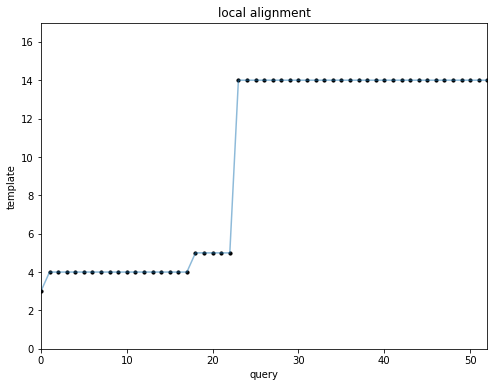

In [28]:
# cost_matrix = get_cost_matrix(template_tpms, query_tpms)#, "correlation")

# LTSA
best_path, best_score = best_alignment_graph(cost_matrix)
plot_alignment(cost_matrix, best_path)

# mapping
query_time = list2floats(query_tpms.columns)
extended_template_time = list2floats(template_tpms.columns)
mapped = pd.DataFrame(data={
    "original_time": query_time,
    "inferred_time": [extended_template_time[i] for i in best_path],
})
alignment_file = "orthologs/dr_mpf_xt_mpf_sample_mapping.tsv"
mapped.to_csv(alignment_file, sep="\t", index=False)  # noqa

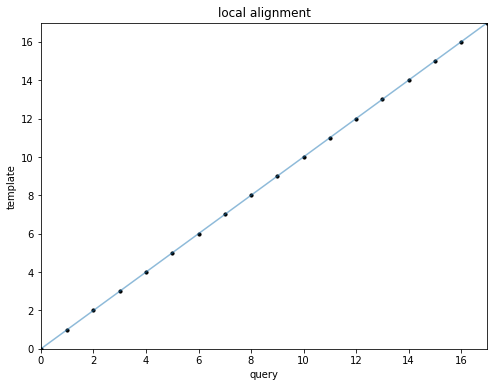

In [29]:
# templtae vs template

cost_matrix = get_cost_matrix(template_tpms, template_tpms)#, "correlation")

# LTSA
best_path, best_score = best_alignment_graph(cost_matrix)
plot_alignment(cost_matrix, best_path)

# mapping
query_time = list2floats(template_tpms.columns)
extended_template_time = list2floats(template_tpms.columns)
mapped = pd.DataFrame(data={
    "original_time": query_time,
    "inferred_time": [extended_template_time[i] for i in best_path],
})
alignment_file = "orthologs/dr_mpf_dr_mpf_sample_mapping.tsv"
mapped.to_csv(alignment_file, sep="\t", index=False)  # noqa

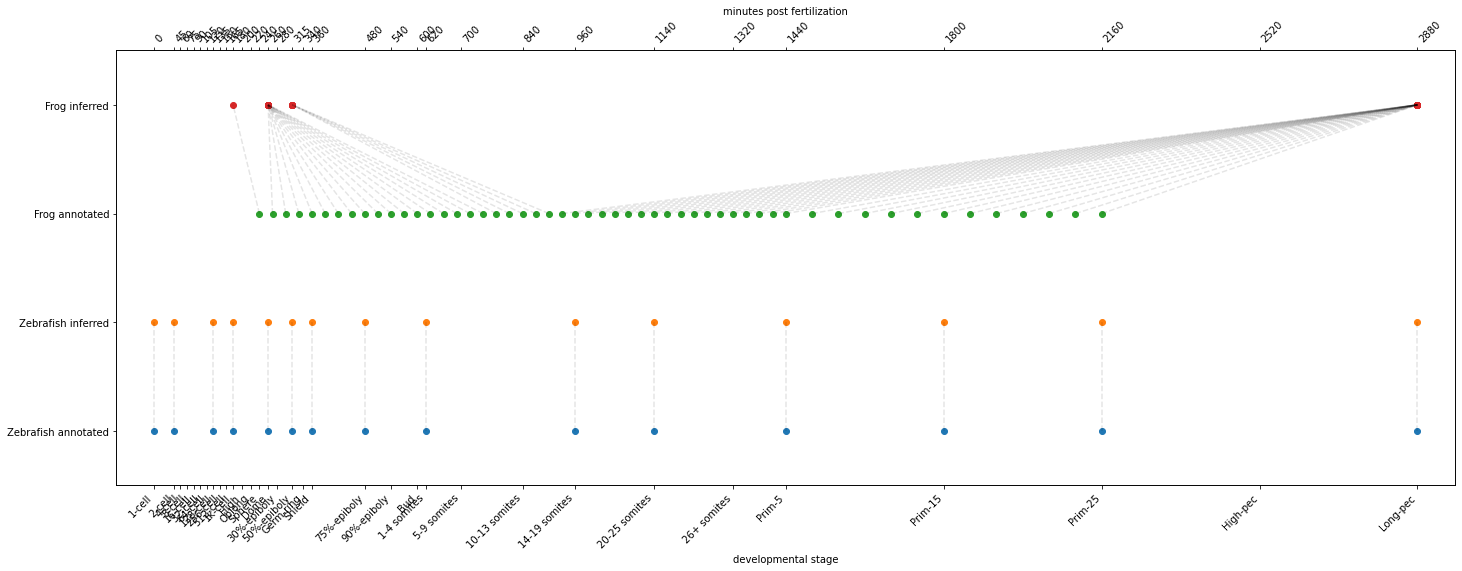

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsa.utils import inference_timeseries


# universal zebrafish time axis (from ZFIN)
all_mpf = [
    0,
    45,
    60,
    75,
    90,
    105,
    120,
    135,
    150,
    165,
    180,
    200,
    220,
    240,
    260,
    280,
    315,
    340,
    360,
    480,
    540,
    600,
    620,
    700,
    840,
    960,
    1140,
    1320,
    1440,
    1800,
    2160,
    2520,
    2880,
    3600,
    4320,
    5760,
    7200,
    8640,
    10080,
    20160,
    30240,
    43200,
    64800,
][:-6]
all_stages = [
    "1-cell",
    "2-cell",
    "4-cell",
    "8-cell",
    "16-cell",
    "32-cell",
    "64-cell",
    "128-cell",
    "256-cell",
    "512-cell",
    "1k-cell",
    "High",
    "Oblong",
    "Sphere",
    "Dome",
    "30%-epiboly",
    "50%-epiboly",
    "Germ-ring",
    "Shield",
    "75%-epiboly",
    "90%-epiboly",
    "Bud",
    "1-4 somites",
    "5-9 somites",
    "10-13 somites",
    "14-19 somites",
    "20-25 somites",
    "26+ somites",
    "Prim-5",
    "Prim-15",
    "Prim-25",
    "High-pec",
    "Long-pec",
    "Pec-fin",
    "Protruding-mouth",
    "Day 4",
    "Day 5",
    "Day 6",
    "Days 7-13",
    "Days 14-20",
    "Days 21-29",
    "Days 30-44",
    "Days 45-89",
][:-6]


#########################################


# query alignments
alignment_files = {
    "Zebrafish": "orthologs/dr_mpf_dr_mpf_sample_mapping.tsv",
    "Frog": "orthologs/dr_mpf_xt_mpf_sample_mapping.tsv",
}

# output plot
plot_file = "orthologs/alignment_dr_xt_sample_orthologs.pdf"

fig = plt.figure(1,figsize = [24, 8])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

# ax1.grid(False)
# ax2.grid(False)

n = 0
ylabels = []
for series in alignment_files:
    df = pd.read_csv(alignment_files[series], sep="\t")
    x1 = df["original_time"]
    x2 = df["inferred_time"]
    plt.scatter(x=x1, y=np.zeros_like(x1) + n)
    n += 1
    plt.scatter(x=x2, y=np.zeros_like(x2) + n)
    n += 1
    ylabels.extend([f"{series} annotated", f"{series} inferred"])
    
    matches = zip(x1, x2)
    for i, j in matches:
        plt.plot((i, j), (n-2, n-1), color = 'black', alpha=0.1, linestyle='--')

# plot shape
x_axis = all_mpf[:-4]
x_labels1 = all_stages[:-4]
x_labels2 = all_mpf[:-4]
x_range = max(x_axis) - min(x_axis)
plt.yticks(list(range(n)), ylabels)
plt.ylim(-0.5, n - 0.5)
plt.ylabel("time series")

total_time = max(x_axis) - min(x_axis)
plt.xlim(min(x_axis) - x_range * 0.03, max(x_axis) + x_range * 0.03)
ax1.set_xlim(ax2.get_xlim())  # for some reason ax2 has the limits we need, but not ax1(?)

ax1.set_xticks(x_axis)
ax1.set_xticklabels(x_labels1, rotation=45, ha="right")
ax1.set_xlabel("developmental stage")

ax2.set_xticks(x_axis)
ax2.set_xticklabels(x_labels2, rotation=45, ha="left")
ax2.set_xlabel("minutes post fertilization")

plt.savefig(plot_file)
plt.show()